In [1]:
import pandas as pd
import pyarrow.feather as feather
import numpy as np
import matplotlib.pyplot as plt

In [2]:
y=np.linspace(0,10)
x=y

In [3]:
crsp=pd.read_csv('CRSP_return 2009-2021.csv')

D:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0,4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
ff_monthly=pd.read_csv('ff_monthly.csv')

In [3]:
ff_monthly

,Unnamed: 0,date,mktrf,smb,hml,rf,year,month,umd,net_ret_ew,gross_ret_ew,net_ret_vw,gross_ret_vw
0,0,1984-01-31,-1.92,-0.37,7.57,0.76,198400.0,100.0,-2.56,-4.912431,-4.839647,-5.140813,-5.079979
1,1,1984-02-29,-4.82,-1.69,3.34,0.71,198400.0,200.0,0.22,-2.885021,-2.885021,-2.885021,-2.885021
2,2,1984-03-30,0.63,0.07,0.47,0.73,198400.0,300.0,1.07,1.649712,1.649712,1.649712,1.649712
3,3,1984-04-30,-0.51,-1.16,1.19,0.81,198400.0,400.0,2.07,-1.281957,-1.209158,-1.231673,-1.167461
4,4,1984-05-31,-5.97,0.07,0.29,0.78,198400.0,500.0,1.51,-6.992356,-6.992356,-6.992356,-6.992356
...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,268,2006-05-31,-3.57,-2.98,2.39,0.43,200600.0,500.0,-3.70,-4.614957,-4.510421,-4.527707,-4.448911
269,269,2006-06-30,-0.35,-0.38,0.80,0.40,200600.0,600.0,1.54,-0.588621,-0.484487,-0.461761,-0.383017
270,270,2006-07-31,-0.78,-3.99,2.62,0.40,200600.0,700.0,-2.13,-2.286239,-2.182572,-1.992534,-1.913849
271,271,2006-08-31,2.03,1.01,-2.04,0.42,200600.0,800.0,-3.38,1.562966,1.666378,1.550772,1.629052


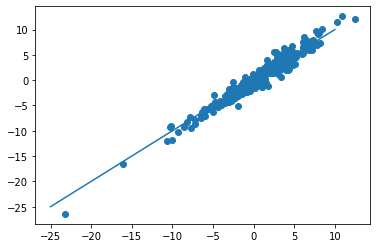

In [14]:
b=np.linspace(-25,10)
a=b
plt.scatter(x,y)
plt.plot(a,b)

In [18]:
import statsmodels.api as sm
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
results.summary()

D:\anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_ret_vw   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     6025.
Date:                Tue, 09 Aug 2022   Prob (F-statistic):          3.89e-187
Time:                        15:47:05   Log-Likelihood:                -382.34
No. Observations:                 273   AIC:                             768.7
Df Residuals:                     271   BIC:                             775.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1288      0.060     -2.136      0.034      -0.247      -0.010
mktrf          1.0554      0.014     77.620      0.000       1.029       1.082
==============================================================================
Omnibus:                        5.183   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                6.956
Skew:                          -0.081   Prob(JB):                       0.0309
Kurtosis:                       3.765   Cond. No.                         4.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
x=ff_monthly['mktrf']
y=ff_monthly['net_ret_vw']